Import necessary packages: Numpy, Pandas, matplotlib

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Mount your google drive (if you have a google account) or upload files (go on the file icon on the left -> right click). Copy path of zip.train and zip.test and load them as numpy arrays using the following code (insert the path as string).

In [74]:
path_to_train = '../data/zip.train'
path_to_test = '../data/zip.test'
training_data = np.array(pd.read_csv(path_to_train, sep=' ', header=None))
test_data = np.array(pd.read_csv(path_to_test, sep =' ',header=None))

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

# We only want to classify two different digits. Note the only difference is
# that we don't load as many ones as we load zeros.

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1][:30]
#print(X_train_1.shape)
X_train = np.vstack((X_train_0, X_train_1))

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1][:30]
y_train = np.hstack((y_train_0, y_train_1))

X_test_0 = X_test[y_test == 0]
X_test_1 = X_test[y_test == 1][:12]
X_test = np.vstack((X_test_0, X_test_1))

y_test_0 = y_test[y_test == 0]
y_test_1 = y_test[y_test == 1][:12]
y_test = np.hstack((y_test_0, y_test_1))
print(y_train.shape)
print(y_test.shape)

(1224,)
(371,)


In [4]:
def show_numbers(X):
    num_samples = 90
    indices = np.random.choice(range(len(X)), num_samples)
    print(indices.shape)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(6, 15, i + 1)
        img = 1-sample_digits[i].reshape((16, 16)) 
        plt.imshow(img, cmap='gray')
        plt.axis('off')


(90,)


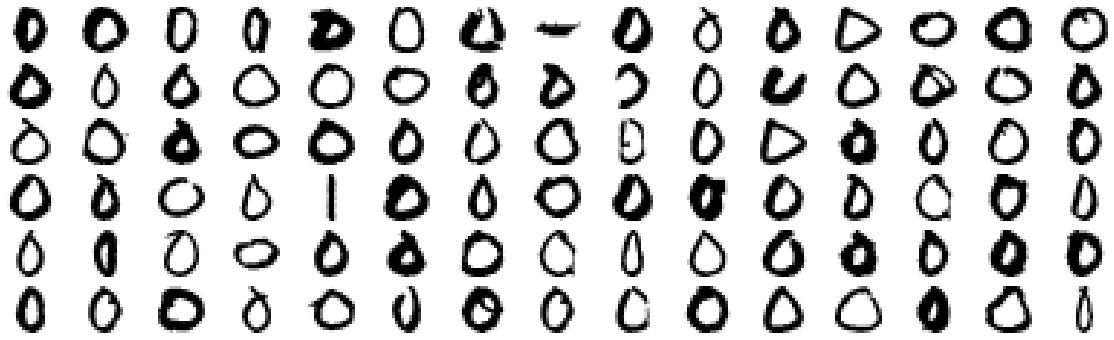

In [5]:
show_numbers(X_test)

Choose one of the classifiers you implemented and use it on the following task: Take a look at the provided notebook. It loads the ZIP-Code’s zeros and ones, but now there are manymore zeros than there are ones. We are going to believe that these digits represent geneticdata. Actually, we are virologists trying to develop a test to determine which of the data belongs to infected patients (the ones) and which do not (the zeros). Train/apply your model on the data and do the tasks of the exercise.

* Exercise 1.
- Use a 5-fold Cross-Validation to evaluate your model. 
- Print the mean and variance of your validation. 
- What do both values tell you about your model?

* Exercise 2.
- Calculate the confusion matrix of your model.

a) How many true positive/true negative/false positive/false negative observations arethere?

(b) Calculate the precision, recall, F1-score and state the difference between accuracy and F1-score

(c) If your test is positive, what is the probability for a patient to be actually positive. Would you recommend using the test you developed? Describe what the problem is if there is one.

I will work with K_NN Classifier

In [6]:
class KNearestNeighbors():
    
    def euclidean_distance(self, x_1, x_2):
        return np.sum((x_1-x_2)**2, axis = 1)

    def fit(self, X_train, y_train):
        # using regulary ML notation
        # https://scikit-learn.org/stable/tutorial/basic/tutorial.html
        # The for classifier is first fitted to the model; that is, it must learn from the model. 
        # This is done by passing our training set to the fit method. 
        self.X = X_train
        self.y = y_train
    
    def predict(self, X_test, k):
        # Now you can predict new values. In this case, we'll predict using the ona sample from the test dataset 
        # By predicting, w’ll determine the image from the training set (LABEL) that best matches the last image
        predictions = []
        for sample in X_test:
            # getting distance for each prticular data point
            distances = self.euclidean_distance(self.X, sample)
            # getting indexes of k first minimal elements
            # elements rearranged in such a way that the value of the element in k-th position 
            # is in the position it would be in a sorted array
            #idx = distances.argsort()[-3:][::-1]
            # https://stackoverflow.com/questions/34226400/find-the-index-of-the-k-smallest-values-of-a-numpy-array
            idx = np.argpartition(distances, k)[:k]
            # taking labels by indexes
            votes = (self.y[idx]).astype(int)
            # the class with maximum votes => the class with minimal distance to k nearest neighbors
            # numpy.argmax(numpy.bincount(dlabel)) returns the most common value found in dlabel.
            predictions.append(np.argmax(np.bincount(votes, minlength=10)))
        return predictions

In [38]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# !!!! Permutation are used. Kept for history

kf = KFold(n_splits=5, random_state=False, shuffle=True)

for train_index, test_index in kf.split(X_train):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train_folds, X_test_folds = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

print("X_train_folds.shape:", X_train_folds.shape)
print("X_test_folds.shape:", X_test_folds.shape)

# PROBLEM WITH KFOLD:
# KFold will return 4 folds for training and 1 fold for testing, the samples will be drop randomly by scklearn
# I have no glue how then to iterate over the folds and change the testing fold
# Solution: use numpy.permutations (as it was planed at the beginning)
# then manually interate over the folds with Python loop

X_train_folds.shape: (980, 256)
X_test_folds.shape: (244, 256)


In [111]:
def calculate_accuracy(labels, predictions):
        return np.mean(labels == predictions)
    
def fit_predict(model, Xc_train, yc_train, Xc_test, yc_test, parameter):
    model.fit(Xc_train, yc_train)
    if parameter is not None:
        res = model.predict(Xc_test, parameter)
    else:
        res = model.predict(Xc_test)
    acc = calculate_accuracy(yc_test, res)
    return res, acc

In [112]:
def cross_validate(model, X_train, y_train, parameter):
    results = []
    accuracies = []
    for i in range(0, 5):
        X_learn = np.concatenate((X_train[0:i*step], X_train[(i+1)*step:]))
        X_val = X_train[i*step:(i+1)*step]
        y_learn = np.concatenate((y_train[0:i*step], y_train[(i+1)*step:]))
        y_val = y_train[i*step:(i+1)*step]
        res, acc = fit_predict(model, X_learn, y_learn, X_val, y_val, parameter)

        results.append(res)
        accuracies.append(acc)
    print("for model {}, accuracy = {}".format(type(model).__name__, accuracies)) 
    return results, accuracies   

In [113]:
from numpy.random import permutation
import math
# DATA PREPARATION
# np.random.permutation is useful when you need to shuffle ordered pairs, especially for classification
# our data is unsuffled: we have to many zeros and a few zeros. All zeros are placed at the end of the set

# Data is currently unshuffled; we should shuffle 
# each X[i] with its corresponding y[i]
perm = permutation(len(X_train))
X_train = X_train[perm]
y_train = y_train[perm]

#print("X_train.shape:", X_train.shape)
#print("X_test.shape:", X_test.shape)

model = KNearestNeighbors()
knn_parameter = 5
step = math.floor(X_train.shape[0] / 5)
results, accs = cross_validate(model, X_train, y_train, knn_parameter)
acc_knn_train = accs

# compare with skleatn KNN
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=knn_parameter)
results, accs = cross_validate(neigh, X_train, y_train, parameter = None)

# Using Logistic regression from sklean
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42, solver='lbfgs')
results, accs = cross_validate(clf, X_train, y_train, parameter = None)



for model KNearestNeighbors, accuracy = [1.0, 1.0, 1.0, 1.0, 1.0]
for model KNeighborsClassifier, accuracy = [1.0, 1.0, 1.0, 1.0, 1.0]
for model LogisticRegression, accuracy = [1.0, 1.0, 1.0, 1.0, 1.0]


In [114]:
# TESTING PHASE ONLY WITH MY KNN
model.fit(X_train, y_train)
predictions = np.array(model.predict(X_test, knn_parameter))
print(results_knn_test)
acc_knn_test = calculate_accuracy(y_test, results_knn_test)
print("AVERAGE ACCURACY of KNN cross-validation: {:.7f}".format(sum(acc_knn_train)/len(acc_knn_train)))
print("TEST ACCURACY of KNN: {:.7f}".format(acc_knn_test))


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [115]:
# How many true positive/true negative/false positive/false negative observations are there?
actual_positive = np.count_nonzero(y_test == 1)
actual_negative = np.count_nonzero(y_test == 0)
print("actual_positive:", actual_positive)
print("actual_negative:", actual_negative)
print("Test actual_positive + actual_negative = y_test: ", actual_positive + actual_negative == y_test.shape[0])

predicted_positives = np.count_nonzero(predictions == 1)
predicted_negatives = np.count_nonzero(predictions == 0)
print("predicted_positives:", predicted_positives)
print("predicted_negatives:", predicted_negatives)
print("Test predicted_positives + predicted_negatives = predictions: ", predicted_positives + predicted_negatives == len(predictions))

actual_positive: 12
actual_negative: 359
Test actual_positive + actual_negative = y_test:  True
predicted_positives: 13
predicted_negatives: 358
Test predicted_positives + predicted_negatives = y_test:  True


In [130]:
# True Positive(TP): Model predicts a positive. Sample is a positive
TP = np.count_nonzero((predictions == 1) & (y_test == 1))
# False Positive(FP): Model predicts a positive. Sample is a negative
FP = np.count_nonzero((predictions == 1) & (y_test == 0))
# True Negative(TN): Model predicts a negative. Data point is a negative
TN = np.count_nonzero((predictions == 0) & (y_test == 0))
# False Negative(FN): Model predicts a negative. Data point is a positive
FN = np.count_nonzero((predictions == 0) & (y_test == 1))

print("TP: {}, FP: {}, TN: {}, FN: {}".format(TP, FP, TN, FN))
print("Test TP + FP + TN + FN = predictions: ", TP + FP + TN + FN ==len(predictions))
print()
print("Confusion matrix:")
print("--------P--------N----")
print("PP     {}        {}".format(TP, FP))
print("PN     {}        {}".format(FN, TN))





TP: 12, FP: 1, TN: 358, FN: 0
Test TP + FP + TN + FN = predictions:  True

Confusion matrix:
--------P--------N----
PP     12        1
PN     0        358


In [151]:
def validate_mertics():
    # Validation Metrics
    P = TP + FN
    N = FP + TN
    # Calculate the precision, recall, F1-score and state the difference between accuracy and F1-score
    # Accuracy is used when the True Positives and True negatives are more important
    # Accuracy can be used when the class distribution is similar
    accuracy = (TP + TN) / (P + N)
    print("Accuracy: {}".format(accuracy))

    # Sensitivity: Aka Recall or True Positive Rate (TPR)
    # Recall is the number of True Positives divided by the number of True Positives and the number of False Negatives
    sensitivity = TP / (TP + FN)
    print("Sensitivity TPR: {}".format(sensitivity))

    # Specificity: Aka Selectivity or True Negative Rate (TNR)
    specificity = TN / (FP + TN)
    print("Specificity TNR: {}".format(specificity))

    # Fallout: Aka False Positive Rate (FPR)
    fallout = FP / (FP + TN)
    print("Fallout FPR: {}".format(fallout))

    # Miss Rate: Aka False Negative Rate (FNR)
    miss_rate = FN / (TP + FN)
    print("Miss Rate FNR: {}".format(miss_rate))

    # (Positive) Precision: Aka Positive Predictive Value (PPV)
    PPV = TP / (TP + FP)
    print("Positive Predictive Value PPV: {}".format(PPV))

    # Negative Precision: Aka Negative Predictive Power (NPV)
    NPV = TN / (FN + TN)
    print("Negative Predictive Power NPV: {}".format(NPV))

    # False Discovery Rate
    FDR = FP / (TP + FP)
    print("False Discovery Rate FDR: {}".format(FDR))

    # False Omission Rate
    FOR = FN / (FN + TN)
    print("False Omission Rate FOR: {}".format(FOR))

    # F1 Score - Harmonic mean of sensitivity and precision
    # F1-score is used when the False Negatives and False Positives are crucial
    # F1-score is a better metric when there are imbalanced classes 
    if sensitivity == 0:
        F1 = 2/ (PPV**-1)
    elif PPV == 0:
        F1 = 2/ (sensitivity**-1)
    else:
        F1 = 2/ ((sensitivity**-1) + (PPV**-1))
    print("F1 Score: {}".format(F1))

    # using another formula 
    # from https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1
    recall = sensitivity
    # precision is TP/(TP+FP). Note that TP+FP is the sum of the first row
    precision = TP / (TP + FP)
    F1_score = (2 * (precision * recall))/(precision + recall)
    print("F1 Score another formula: {}".format(F1_score))
    
    return sensitivity, F1

validate_mertics()

Accuracy: 0.9973045822102425
Sensitivity TPR: 1.0
Specificity TNR: 0.9972144846796658
Fallout FPR: 0.002785515320334262
Miss Rate FNR: 0.0
Positive Predictive Value PPV: 0.9230769230769231
Negative Predictive Power NPV: 1.0
False Discovery Rate FDR: 0.07692307692307693
False Omission Rate FOR: 0.0
F1 Score: 0.9600000000000002
F1 Score another formula: 0.9600000000000001


(1.0, 0.9600000000000002)

* if your test is positive, what is the probability for a patient to be actually positive. Would you recommend using the test you developed? Describe what the problem is if there is one.
Test is positive: Positive Predictive Value PPV: 0.92
Test has very low False Positive Rate = 0.0.023 and there is no miss rate at all.
Sensitivity is ideal 1.0
Test is ideal positive corresponding to F1 Score

Honestly say, the "ones" and "zeros" distinguish too obviously. Probably, if "positive" would be a handwritten "6" and a "negative" would be a handwritten "5" we would have much lower sensitivity because these numbers is harder to recognize. 